In [1]:
from contractions import contractions_dict

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd 
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline, set_seed
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments

import datasets
from datasets import load_metric, Dataset
from datasets import DatasetDict

from tqdm import tqdm

import wandb

import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt")

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /Users/kysgattu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def expand_contractions(text, contraction_map=None):
    if contraction_map is None:
        contraction_map = contractions_dict

    # Using regex for getting all contracted words
    contractions_keys = '|'.join(re.escape(key) for key in contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    expanded_text = contractions_pattern.sub(lambda match: contraction_map.get(match.group(0), match.group(0)), text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# Example usage
expand_contractions("y'all can't expand contractions i'd think")


'you all cannot expand contractions id think'

In [4]:
entertainment = pd.read_csv('data/BBCNewsSummaryCSV/entertainment_data.csv') 
sport = pd.read_csv('data/BBCNewsSummaryCSV/sport_data.csv')
tech = pd.read_csv('data/BBCNewsSummaryCSV/tech_data.csv')

In [5]:
print(entertainment.head())

            filename                                        newsarticle  \
0  entertainment_001  Gallery unveils interactive tree\n\nA Christma...   
1  entertainment_002  Jarre joins fairytale celebration\n\nFrench mu...   
2  entertainment_003  Musical treatment for Capra film\n\nThe classi...   
3  entertainment_004  Richard and Judy choose top books\n\nThe 10 au...   
4  entertainment_005  Poppins musical gets flying start\n\nThe stage...   

                                             summary  
0  The messages will be "unwrapped" by sculptor R...  
1  Bloom is to be formally presented with the Han...  
2  The classic film It's A Wonderful Life is to b...  
3  "It was very hard to follow last year's extrem...  
4  Mary Poppins was originally created by author ...  


In [6]:
training_dataset = pd.concat([entertainment,sport,tech], ignore_index=True)

In [7]:
training_dataset = training_dataset.sample(frac=1).reset_index(drop=True)

In [8]:
training_dataset.head()

,filename,newsarticle,summary
0,tech_101,Bush website blocked outside US\n\nSurfers out...,Since then people outside the US trying to bro...
1,sport_193,Real in talks over Gravesen move\n\nReal Madri...,Real Madrid are closing in on a Â£2m deal for ...
2,entertainment_153,OutKast win at MTV Europe Awards\n\nUS hip-hop...,OutKast did lose out in the contest for best a...
3,entertainment_283,Prodigy join V Festival line-up\n\nEssex act P...,"A month later at the V Festival, Prodigy will ..."
4,tech_334,Security warning over 'FBI virus'\n\nThe US Fe...,An attachment in the e-mail contains the virus...


In [9]:
def getSenLen(sentence):
    return len(sentence.split())

In [10]:
training_dataset['article_length'] = training_dataset['newsarticle'].apply(getSenLen)
training_dataset['summary_length'] = training_dataset['summary'].apply(getSenLen)

In [11]:
training_dataset

,filename,newsarticle,summary,article_length,summary_length
0,tech_101,Bush website blocked outside US\n\nSurfers out...,Since then people outside the US trying to bro...,355,139
1,sport_193,Real in talks over Gravesen move\n\nReal Madri...,Real Madrid are closing in on a Â£2m deal for ...,232,113
2,entertainment_153,OutKast win at MTV Europe Awards\n\nUS hip-hop...,OutKast did lose out in the contest for best a...,599,239
3,entertainment_283,Prodigy join V Festival line-up\n\nEssex act P...,"A month later at the V Festival, Prodigy will ...",233,97
4,tech_334,Security warning over 'FBI virus'\n\nThe US Fe...,An attachment in the e-mail contains the virus...,215,101
...,...,...,...,...,...
1293,tech_296,Gadget market 'to grow in 2005'\n\nThe explosi...,The explosion in consumer technology is to con...,636,241
1294,entertainment_146,J-Lo and husband plan debut duet\n\nSingers Je...,The tsunami tribute song will also feature Ali...,271,121
1295,tech_314,Junk e-mails on relentless rise\n\nSpam traffi...,"The figures, from e-mail management firm Email...",245,91
1296,sport_444,Hewitt falls to Dent\n\nLleyton Hewitt suffere...,Dent will face Juan Ignacio Chela next after t...,149,58


In [12]:
training_dataset.describe()

,article_length,summary_length
count,1298.000000,1298.000000
mean,383.246533,165.270416
std,241.582739,109.734916
min,114.000000,42.000000
25%,234.000000,99.250000
50%,321.000000,137.000000
75%,464.000000,202.750000
max,3482.000000,1706.000000


Text(0.5, 1.0, 'Boxplot of Summary Lengths')

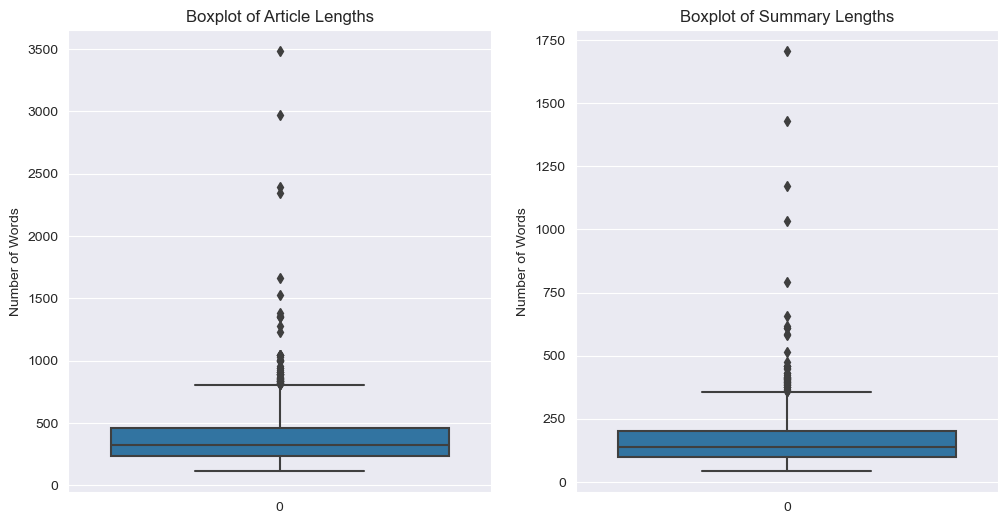

In [13]:
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for the articles' number of words
sns.boxplot(training_dataset["article_length"], ax=axes[0])
axes[0].set_ylabel("Number of Words")
axes[0].set_title("Boxplot of Article Lengths")

# Plot for the summaries' number of words
sns.boxplot(training_dataset["summary_length"], ax=axes[1])
axes[1].set_ylabel("Number of Words")
axes[1].set_title("Boxplot of Summary Lengths")


In [14]:
# Get statistics for the articles boxplot
lines_articles = axes[0].lines[:6]
articles_stats = [line.get_ydata()[0] for line in lines_articles]
Q1_articles, Q3_articles, lower_whisker_articles, upper_whisker_articles, median_articles = articles_stats[:5]

# Get statistics for the summaries boxplot
lines_summaries = axes[1].lines[:6]
summaries_stats = [line.get_ydata()[0] for line in lines_summaries]
Q1_summaries, Q3_summaries, lower_whisker_summaries, upper_whisker_summaries, median_summaries = summaries_stats[:5]

In [15]:
training_dataset = training_dataset[(training_dataset['summary_length'] <= upper_whisker_summaries) & (training_dataset['article_length'] <= upper_whisker_articles)]

In [16]:
training_dataset.head()

,filename,newsarticle,summary,article_length,summary_length
0,tech_101,Bush website blocked outside US\n\nSurfers out...,Since then people outside the US trying to bro...,355,139
1,sport_193,Real in talks over Gravesen move\n\nReal Madri...,Real Madrid are closing in on a Â£2m deal for ...,232,113
2,entertainment_153,OutKast win at MTV Europe Awards\n\nUS hip-hop...,OutKast did lose out in the contest for best a...,599,239
3,entertainment_283,Prodigy join V Festival line-up\n\nEssex act P...,"A month later at the V Festival, Prodigy will ...",233,97
4,tech_334,Security warning over 'FBI virus'\n\nThe US Fe...,An attachment in the e-mail contains the virus...,215,101


In [17]:
import json
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torch.callbacks import ModelCheckpoint

from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    AutoTokenizer,
    T5TokenizerFast as T5Tokenizer
)

from tqdm.auto import tqdm
from pylab import rcParams
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

ModuleNotFoundError: No module named 'pytorch_lightning'